In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/Shareddrives/Kaggle/Kaggle/Scripts/')

Mounted at /content/drive


In [ ]:
!pip install catboost
!pip install install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from bayes_opt import BayesianOptimization

In [ ]:
train = pd.read_csv('/content/drive/Shareddrives/Kaggle/Kaggle/Data/trainknn_all.csv')
test = pd.read_csv('/content/drive/Shareddrives/Kaggle/Kaggle/Data/test_all.csv')
target = 'contest-tmp2m-14d__tmp2m'

## Train and Validation

In [ ]:
X = train.drop([target],axis = 1, inplace=False)
y = train[target]
X_test = test[X.columns]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
print(f'Train_shape: {X_train.shape}    |   Val_shape: {X_val.shape}    |   Test_shape: {X_test.shape}')

Train_shape: (251741, 268)    |   Val_shape: (123993, 268)    |   Test_shape: (31354, 268)


## Adversarial Validation

In [ ]:
import lightgbm as lgb

def run_adversial_validation(train_X_ml, test_X_ml):
    
    lgb_params = {'n_estimators':100,
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'verbose': 0
                    }
    # combine train & test features, create label to identify test vs train
    ad_y = np.array([1]*train_X_ml.shape[0] + [0]*test_X_ml.shape[0])
    ad_X = pd.concat([train_X_ml, test_X_ml])

    # evaluate model performance using cross-validation
    lgb_data = lgb.Dataset(ad_X, ad_y)
    cv_lgb = lgb.cv(lgb_params, lgb_data)

    print("Adversarial Validation AUC Score: {}".format(cv_lgb['auc-mean'][-1]))
    
    # train model & get feature importance
    ad_val_mod = lgb.train(lgb_params, lgb_data)
    
    print(pd.DataFrame(
        {'feat':ad_X.columns, 
         'imp':ad_val_mod.feature_importance()}).sort_values('imp', ascending = False))
    
    return ad_val_mod

In [ ]:
ad_val_mod = run_adversial_validation(X_train, X_test)

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Adversarial Validation AUC Score: 1.0


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


                                   feat  imp
0                            Unnamed: 0  552
3    contest-pevpr-sfc-gauss-14d__pevpr  374
140                            mei__mei  102
126                wind-uwnd-250-2010-9   96
2                                   lon   84
..                                  ...  ...
150                 wind-hgt-850-2010-8    0
152                wind-hgt-850-2010-10    0
153                          sst-2010-1    0
155                          sst-2010-3    0
267                                 Dwb    0

[268 rows x 2 columns]


In [ ]:
X.drop(['contest-pevpr-sfc-gauss-14d__pevpr','mei__mei','wind-uwnd-250-2010-9'], axis = 1, inplace = True)
X_test.drop(['contest-pevpr-sfc-gauss-14d__pevpr','mei__mei','wind-uwnd-250-2010-9'], axis = 1, inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
X.drop(['Unnamed: 0'], axis = 1, inplace = True)
X_test.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
X.head()

,lat,lon,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010-5,wind-uwnd-925-2010-6,wind-uwnd-925-2010-7,wind-uwnd-925-2010-8,wind-uwnd-925-2010-9,wind-uwnd-925-2010-10,wind-uwnd-925-2010-11,wind-

## Bayesian Optimization for CatBoost

In [ ]:
# source: https://medium.com/ai-in-plain-english/catboost-cross-validated-bayesian-hyperparameter-tuning-91f1804b71dd

X1, Y1 = X.copy(), y.copy()

from catboost import Pool, cv, CatBoostRegressor
from bayes_opt import BayesianOptimization
from bayes_opt import BayesianOptimization as BO
import warnings
from sklearn.model_selection import * 
from sklearn.metrics import *

def rmse(actual, predicted):
    return mean_squared_error(actual, predicted, squared=False)

Use_BO = True

if Use_BO:
    #n_estimators,
    # num_leaves
    def CB_opt(iterations, depth, learning_rate, subsample, l2_leaf_reg, model_size_reg): 

        scores = []
    #     skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1944)
        trainx, valx, trainy, valy = train_test_split(X1, Y1, test_size=0.33, random_state=42)

        reg = CatBoostRegressor(   
                                        verbose = 0,
                                        iterations=int(iterations),
                                        #n_estimators = 10,
                                        learning_rate = learning_rate,
                                        subsample = subsample, 
                                        l2_leaf_reg = l2_leaf_reg,
                                        max_depth = int(depth),
                                        #num_leaves = int(num_leaves),
                                        random_state = 1212,
                                        #grow_policy = "Lossguide",
    #                                     max_bin = int(max_bin),  
                                        use_best_model = True, 
                                        # bootstrap_type='Bayesian',
                                        loss_function='RMSE',
                                        model_size_reg = model_size_reg
                                    )

        reg.fit(trainx, trainy, eval_set = (valx, valy))
        y_pred = reg.predict(valx)
        scores.append(rmse(valy, y_pred))

        return 1/np.mean(scores)

    #"n_estimators": (150,1200),
    # "num_leaves": (100,150),
    # "max_bin":(150,300),
    pbounds = {
               "iterations": (1000,25000),
               "depth": (6, 7),
               "learning_rate": (0.09, 0.0980689972639084),
               "subsample":(0.7, 0.800000011920929),
               "l2_leaf_reg":(2,4),
               "model_size_reg": (0.48, 0.5)
    }

    optimizer = BayesianOptimization(f = CB_opt, pbounds = pbounds,  verbose = 2, random_state = 1212)

    optimizer.maximize(init_points = 7, n_iter = 30, acq = 'ucb', alpha = 1e-6)

    print(optimizer.max)

    max_bo_params = optimizer.max['params']

    max_bo_params

|   iter    |  target   |   depth   | iterat... | l2_lea... | learni... | model_... | subsample |
-------------------------------------------------------------------------------------------------


<ipython-input-9-c2ae1505c78b>:64: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  optimizer.maximize(init_points = 7, n_iter = 30, acq = 'ucb', alpha = 1e-6)


KeyboardInterrupt: ignored

In [ ]:
Use_BO_result = False

if Use_BO_result:
    opt_params = {
              'iterations':2000,
              'verbose':0,
              'learning_rate' : max_bo_params['learning_rate'],
              'subsample' : max_bo_params['subsample'], 
              'l2_leaf_reg' : max_bo_params['l2_leaf_reg'],
              'max_depth' : int(max_bo_params['depth']), 
              'use_best_model' : True, 
              'loss_function' : 'RMSE',
              'model_size_reg' : max_bo_params['model_size_reg'],
             }
else:
    opt_params = {
          'iterations':25000,
          'verbose':0,
          'learning_rate' : 0.0980689972639084,
          'subsample' : 0.7443133148363695, 
          'l2_leaf_reg' : 2.3722386345448316,
          'max_depth' : int(6.599144674342465),
          'use_best_model' : True, 
          'loss_function' : 'RMSE',
          'model_size_reg' : 0.4833187897595954,
         }

In [ ]:
## catBoost Pool object
train_pool = Pool(data=X1,label = Y1)

X_train, X_test2, y_train, y_test = train_test_split(X1, Y1, test_size=0.33, random_state=42)

bst = CatBoostRegressor(**opt_params)
bst.fit(train_pool, eval_set=(X_test2, y_test), plot=False,silent=True)
print(bst.get_best_score())

{'learn': {'RMSE': 0.09913299633950286}, 'validation': {'RMSE': 0.09906089321880328}}


In [ ]:
y_pred_cat = bst.predict(X_test)

In [ ]:
submit = pd.read_csv('/content/drive/Shareddrives/Kaggle/Kaggle/Output/sample_solution.csv')
submit[target] = y_pred_cat
with open('/content/drive/Shareddrives/Kaggle/Kaggle/Output/solution_v24.csv', 'w', encoding = 'utf-8-sig') as f:
    submit.to_csv(f,index=False)

## Feature Importance

Text(0.5, 1.0, 'Feature Importance')

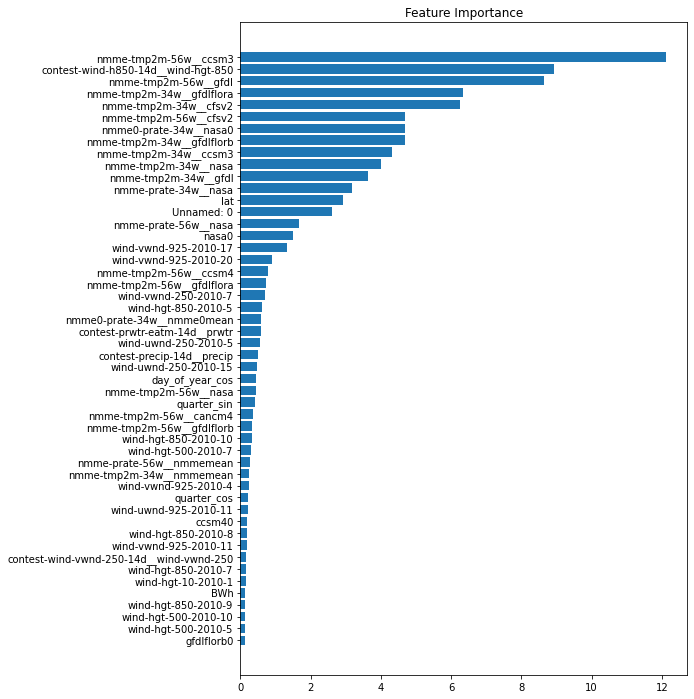

In [ ]:
import matplotlib.pyplot as plt
feature_importance = bst.feature_importances_
max_features = 50
sorted_idx = np.argsort(feature_importance)[-max_features:]
fig = plt.figure(figsize=(8, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

## Machine Learning Explainability


In [ ]:
import shap

explainer = shap.Explainer(bst)
shap_values = explainer(X1)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])


ModuleNotFoundError: ignored

## Pseudo Labeling and Postprocessing


In [ ]:
# Pseudo Labelling
train_pseudo = X_test.copy()
ddf = pd.read_csv('/kaggle/input/wids-2023-sub3/submission (17).csv')
y_test_pred  = ddf[target].values.flatten() #ddf[target] #bst.predict(X_test)
train_pseudo[target] = y_test_pred

X_train_pseudo = X_train.copy() 
X_train_pseudo[target] = y_train

train_mod = pd.concat([X_train_pseudo.copy(), train_pseudo], axis=0).reset_index(drop=True)
features = [c for c in X_test.columns if (c != 'id')]
display(train_mod)

XX = train_mod[features]
yy = train_mod[target]
y_oof_pred = np.zeros(len(yy))

X_testt = X_test[features].values
y_test_pred2 = np.zeros(len(X_testt))

In [ ]:
yy[np.isnan(yy)] = 0
train_pool = Pool(data=XX,label = yy)

X_train3, X_test3, y_trai3, y_test3 = train_test_split(XX, yy, test_size=0.33, random_state=42)

bst2 = CatBoostRegressor(**opt_params)
bst2.fit(train_pool, eval_set=(X_test3, y_test3), plot=True,silent=True)
print(bst2.get_best_score())

## Ensemble Learning


In [ ]:
import lightgbm as lgb

# set up parameters for LightGBM
params = {'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'max_depth': 4,
          'num_leaves': 31,
          'learning_rate': 0.05,
          'feature_fraction': 0.9,
          'bagging_fraction': 0.8,
          'bagging_freq': 5,
          'early_stopping_round': 50,
          'n_estimators': 15000,
          'num_iterations':100}

reg_lgb = lgb.LGBMRegressor(**params)

reg_lgb.fit(X_train3, y_trai3, eval_set=(X_test3, y_test3),verbose=100)

y_pred_cat = bst2.predict(X_test)

y_pred_lgb = reg_lgb.predict(X_test)


In [ ]:
import xgboost as xgb
reg_xgb = xgb.XGBRegressor(base_score=0.5, 
                           n_estimators=15000,
                           objective='reg:linear',
                           max_depth=4,
                           early_stopping_rounds=100,
                           learning_rate=0.01)

reg_xgb.fit(X_train3, y_trai3, eval_set=((X_test3, y_test3),), verbose=100)

y_pred_xgb = reg_xgb.predict(X_test)

In [ ]:
ensemble_preds = y_pred_lgb*0.51+y_pred_cat*0.42+y_pred_xgb*0.07

In [ ]:
submit = pd.read_csv('/content/drive/Shareddrives/Kaggle/Kaggle/Output/sample_solution.csv')

submit_cat = submit.copy()
submit_cat[target] = y_pred_cat
submit_cat.to_csv('y_pred_cat.csv', index = False)

submit_lgb = submit.copy()
submit_lgb[target] = y_pred_lgb
submit_lgb.to_csv('y_pred_lgb.csv', index = False)

submit_xgb = submit.copy()
submit_xgb[target] = y_pred_xgb
submit_xgb.to_csv('y_pred_xgb.csv', index = False)

In [ ]:
submit[target] = ensemble_preds
with open('/content/drive/Shareddrives/Kaggle/Kaggle/Output/solution_v24.csv', 'w', encoding = 'utf-8-sig') as f:
    submit.to_csv(f,index=False)